#Clarification and Study Design

RQ: How do different machine learning models compare in predictive performance
and interpretability when trained on Junyi Academy log data to predict
student performance?

For this study, the code is segmented into 3 section in order to address the following question:
{RQ1 Among standard Graph Neural Network models, which model achieves the
best predictive performance, and how do these GNNs models compare with
a standard Random Forest model?}

{RQ2 Does the dynamic-graph extension of GNNs model, EvolveGCN, further
improve predictive performance over static GNNs models?}

{RQ3 According to SHAP and GNNExplainer, which features drive each model’s
predictions, and do community-support variables emerge as influential
features?
}

what connect students -> edge
basically the log file can be treated as edge
basically the hierarchy is this: level4_id is the course topic > ucid is the exercise id > upid is the practice id
so students can be connected by if they have done the same ucid and upid


# Import

In [ ]:

#!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric torch-geometric-temporal numpy
!pip install torch==2.2.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric-temporal
!pip install shap optuna
!pip install "numpy<2"

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

In [ ]:
import copy
import itertools
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedShuffleSplit,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

import torch
import torch_sparse
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv, GATConv, SAGEConv
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.explain import Explainer, GNNExplainer
import random, time
from sklearn.neighbors import NearestNeighbors
import shap

from google.colab import drive

In [ ]:
'''
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
user = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Info_UserData.csv")
course = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Info_Content.csv")
log = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Log_Problem.csv")
#merge files for better readability
df = log.merge(user, how='left', on='uuid')
df = df.merge(course, how='left', on='ucid')
#df = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/processed_revised.csv").drop(columns=['Unnamed: 0'])
'''

# Data Processing

In [ ]:
#column transform
df = df.drop(columns=['gender','content_kind','content_pretty_name','subject','level1_id','level2_id','level3_id','level4_id','is_downgrade', 'is_upgrade']) #subject is all math

df = pd.get_dummies(df, columns=['learning_stage', 'difficulty'])

for col in ['is_correct', 'is_hint_used', 'is_self_coach']:
    df[col] = df[col].map({True: 1, False: 0, 'unknown': np.nan})

for col in ['exercise_problem_repeat_session', 'points', 'badges_cnt','total_sec_taken']:
  df[col] = np.log1p(df[col])

scaler = MinMaxScaler(feature_range=(0, 1))
for col in ['belongs_to_class_cnt','total_attempt_cnt', 'used_hint_cnt', 'has_teacher_cnt']:
  df[col] = scaler.fit_transform(df[[col]])

le = LabelEncoder()
df['level_encoded'] = le.fit_transform(df['level'])
df = df.drop(columns=['level'])
df['user_city_encoded'] = le.fit_transform(df['user_city'])
df = df.drop(columns=['user_city'])

df['timestamp_TW'] = pd.to_datetime(df['timestamp_TW']).dt.tz_localize(None)
df['is_correct'] = df['is_correct'].astype('category')
df['is_hint_used'] = df['is_hint_used'].astype('category')
df['first_login_date_TW'] = pd.to_datetime(df['first_login_date_TW'])
df['has_student_cnt'] = df['has_student_cnt'].astype(int)
df['has_class_cnt'] = df['has_class_cnt'].astype(int)

In [ ]:
df.head(3)

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,points,badges_cnt,first_login_date_TW,user_grade,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,learning_stage_elementary,learning_stage_junior,learning_stage_senior,difficulty_easy,difficulty_hard,difficulty_normal,difficulty_unset,level_encoded,user_city_encoded
0,2019-05-26 21:00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,1.098612,1.0,3.526361,0.001,0.0,0.0,11.785750,2.833213,2019-03-23,7,0.009434,0.0,0,0.008333,1,False,True,False,False,False,True,False,3,16
1,2019-05-17 16:30:00,+Gqj2nalc6M9fusyVECTC0AN7UQdDQTXESIuElkDltU=,COZ39Wo+uIUO2s7c2VGEHjJf6Vx0xifxVAiaeHtaTdk=,Ek+pIeHNNoEo0tGEq91eBcBmGgy3+A5RWhpj95zTyHM=,4,0.693147,1.0,2.197225,0.001,0.0,0.0,12.111168,3.828641,2018-11-23,5,0.009434,0.0,0,0.008333,0,True,False,False,True,False,False,False,0,12
2,2019-05-15 19:15:00,6D5QN8j8ng/VR74ES3A0zqAj0bIFFyaKjKEj8ZyXjQ8=,TwyqyV1uJYlDAX8wX/PtTCVZEBo/APIVfTzzleGkNCQ=,1MBa2f5Qog4JBoAuUfJf0fxeJctdEirAqKgfsg246eI=,9,0.693147,1.0,2.890372,0.001,0.0,0.0,12.469817,3.218876,2019-05-15,5,0.009434,0.0,0,0.008333,0,True,False,False,True,False,False,False,0,11


## Feature

In [ ]:
#feature engineering
df['hour'] = df['timestamp_TW'].dt.hour
df['day_of_week'] = df['timestamp_TW'].dt.dayofweek
df['month'] = df['timestamp_TW'].dt.month
df['year'] = df['timestamp_TW'].dt.year
df['days_since_first_login'] = (df['timestamp_TW'] - df['first_login_date_TW']).dt.days

In [ ]:
df.head(2)

,timestamp_TW,uuid,ucid,upid,problem_number,exercise_problem_repeat_session,is_correct,total_sec_taken,total_attempt_cnt,used_hint_cnt,is_hint_used,points,badges_cnt,first_login_date_TW,user_grade,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,learning_stage_elementary,learning_stage_junior,learning_stage_senior,difficulty_easy,difficulty_hard,difficulty_normal,difficulty_unset,level_encoded,user_city_encoded,hour,day_of_week,month,year,days_since_first_login
0,2019-05-26 21:00:00,FLy+lviglNR5Y1l0Xiijnl6QHySBcpKHJLCtQ6ogm2Q=,KDOmuTrY/IJzDP4kIgIYCBiGyTymsJ8Iy4cDB35WGYg=,Vbs92l4JmdiWkUEm/iahxnUTaac2oN1IlUtXB7JcfoE=,18,1.098612,1.0,3.526361,0.001,0.0,0.0,11.785750,2.833213,2019-03-23,7,0.009434,0.0,0,0.008333,1,False,True,False,False,False,True,False,3,16,21,6,5,2019,64
1,2019-05-17 16:30:00,+Gqj2nalc6M9fusyVECTC0AN7UQdDQTXESIuElkDltU=,COZ39Wo+uIUO2s7c2VGEHjJf6Vx0xifxVAiaeHtaTdk=,Ek+pIeHNNoEo0tGEq91eBcBmGgy3+A5RWhpj95zTyHM=,4,0.693147,1.0,2.197225,0.001,0.0,0.0,12.111168,3.828641,2018-11-23,5,0.009434,0.0,0,0.008333,0,True,False,False,True,False,False,False,0,12,16,4,5,2019,175


In [ ]:
# 1. Compute rolling 7-day login count and merge into original df
# Prepare daily counts
daily = (
    df.assign(date=df['timestamp_TW'].dt.floor('d'))
      .groupby(['uuid', 'date'])
      .size()
      .rename('logins_per_day')
      .reset_index()
)
# Expand to all dates and compute rolling sum
full_idx = (
    daily.groupby('uuid')['date']
         .apply(lambda dates: pd.date_range(dates.min(), dates.max(), freq='D'))
         .explode()
         .rename('date')
         .reset_index()
)
rolling = (
    full_idx
      .merge(daily, on=['uuid', 'date'], how='left')
      .fillna({'logins_per_day': 0})
      .set_index('date')
      .groupby('uuid')['logins_per_day']
      .rolling('7D')
      .sum()
      .rename('rolling_login_7d')
      .reset_index()
)
# Merge rolling feature
df = (
    df.assign(date=df['timestamp_TW'].dt.floor('d'))
      .merge(rolling, on=['uuid', 'date'], how='left')
      .drop(columns=['date'])
)

# 2. Aggregate per user statistics
user_stats = (
    df.groupby('uuid')
      .agg(
        max_days_since_first_login=('days_since_first_login', 'max'),
        avg_hints=('used_hint_cnt', 'mean'),
        unique_login_days=('timestamp_TW', lambda s: s.dt.date.nunique()),
        has_teacher=('has_teacher_cnt', lambda x: int((x > 0).any())),
        is_self_coach=('is_self_coach', 'max'),  # already 0/1
        has_student=('has_student_cnt', lambda x: int((x > 0).any())),
        belongs_to_class=('belongs_to_class_cnt', lambda x: int((x > 0).any())),
        has_class=('has_class_cnt', lambda x: int((x > 0).any()))
      )
      .reset_index()
)
# Compute average weekly login frequency
user_stats['active_weeks'] = user_stats['max_days_since_first_login'].div(7).replace(0, 1)
user_stats['avg_weekly_login_freq'] = (
    user_stats['unique_login_days'] / user_stats['active_weeks']
)
user_stats.drop(columns=['active_weeks', 'unique_login_days'], inplace=True)

df = df.merge(user_stats, on='uuid', how='left')

In [ ]:
df.to_csv("/content/drive/My Drive/Thesis/processed_revised.csv")

#Call df

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df = pd.read_csv("/content/drive/My Drive/Thesis/processed_revised.csv").drop(columns=['Unnamed: 0','is_self_coach_y'])

Mounted at /content/drive


In [ ]:
#filter out those who have done less than 10 exercises
user_log_counts = df.groupby('uuid').size().reset_index(name='log_count')
users_with_enough_logs = user_log_counts[user_log_counts['log_count'] >= 100]
valid_users_uuids = users_with_enough_logs['uuid'].tolist()
df_filtered = df[df['uuid'].isin(valid_users_uuids)]
df = df_filtered
df['proficient'] = df_filtered.groupby('uuid')['level_encoded'].transform(lambda x: (x > 3).any()).astype(int)
#drop repeated columns that used original ones to create:
'''
max_days_since_first_login=('days_since_first_login', 'max'),
avg_hints=('used_hint_cnt', 'mean'),
unique_login_days=('timestamp_TW', lambda s: s.dt.date.nunique()),
has_teacher=('has_teacher_cnt', lambda x: int((x > 0).any())),
is_self_coach=('is_self_coach', 'max'),  # already 0/1
has_student=('has_student_cnt', lambda x: int((x > 0).any())),
belongs_to_class=('belongs_to_class_cnt', lambda x: int((x > 0).any())),
has_class=('has_class_cnt', lambda x: int((x > 0).any()))
'''
df = df.drop(columns=['days_since_first_login','used_hint_cnt','has_teacher_cnt','has_student_cnt','belongs_to_class_cnt','has_class_cnt'])

In [ ]:
'''
df_sorted = df.sort_values(by='timestamp_TW', ascending=False)
for col in df_sorted.columns:
  if df_sorted[col].dtype.name == 'category' or df_sorted[col].dtype == 'object':
      try:
          df_sorted[col] = df_sorted[col].astype(float)
      except:
          df_sorted[col] = df_sorted[col].astype('category').cat.codes
agg_dict = {
    'last_activity':('timestamp_TW','max'), #rename timestamp_TW to last_activity
    'first_login_date_TW':('first_login_date_TW','min'),
    'rolling_login_7d':('rolling_login_7d', 'max'),
    'max_days_since_first_login':('max_days_since_first_login','max'),

    'problem_number':('problem_number','nunique'),
    'exercise_problem_repeat_session':('exercise_problem_repeat_session','mean'),
    'is_correct':('is_correct','mean'),
    'total_sec_taken':('total_sec_taken','mean'),
    'total_attempt_cnt':('total_attempt_cnt','mean'),
    'is_hint_used':('is_hint_used','mean'),
    'points':('points','max'),
    'badges_cnt':('badges_cnt','max'),
    'avg_hints':('avg_hints','max'),
    'avg_weekly_login_freq':('avg_weekly_login_freq','max'),

    'is_self_coach_x':('is_self_coach_x','max'),
    'has_teacher':('has_teacher','max'),
    'has_student':('has_student','max'),
    'belongs_to_class':('belongs_to_class','max'),
    'has_class':('has_class','max'),

    'learning_stage_elementary': ('learning_stage_elementary', 'mean'),
    'learning_stage_junior':('learning_stage_junior','mean'),
    'learning_stage_senior':('learning_stage_senior','mean'),
    'difficulty_easy':('difficulty_easy','mean'),
    'difficulty_normal':('difficulty_normal','mean'),
    'difficulty_hard':('difficulty_hard','mean'),
    'difficulty_unset':('difficulty_unset','mean'),

    'hour':('hour','mean'),
    'day_of_week':('day_of_week','nunique'),
    'month':('month','nunique'),
    'year':('year','nunique'),

    'user_grade':('user_grade','max'),
    'user_city_encoded':('user_city_encoded','last'),
    'level_encoded':('level_encoded','max'),
    'proficient':('proficient','max'),
}
df_user = df_sorted.groupby('uuid').agg(**agg_dict).reset_index()
'''
df.rename(columns={'timestamp_TW': 'last_activity'}, inplace=True)

In [ ]:
len(df_user)

28737

In [ ]:
len(df)

14855626

In [ ]:
#make sure they have the same columns, df keep ucid, upid for later use
print(df.columns)
print(df_user.columns)

Index(['last_activity', 'uuid', 'ucid', 'upid', 'problem_number', 'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken', 'total_attempt_cnt', 'is_hint_used', 'points', 'badges_cnt', 'first_login_date_TW', 'user_grade', 'is_self_coach_x', 'learning_stage_elementary', 'learning_stage_junior', 'learning_stage_senior', 'difficulty_easy', 'difficulty_hard', 'difficulty_normal', 'difficulty_unset', 'level_encoded', 'user_city_encoded', 'hour', 'day_of_week', 'month', 'year', 'rolling_login_7d', 'max_days_since_first_login', 'avg_hints', 'has_teacher', 'has_student', 'belongs_to_class', 'has_class', 'avg_weekly_login_freq', 'proficient'], dtype='object')
Index(['uuid', 'last_activity', 'first_login_date_TW', 'rolling_login_7d', 'max_days_since_first_login', 'problem_number', 'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken', 'total_attempt_cnt', 'is_hint_used', 'points', 'badges_cnt', 'avg_hints', 'avg_weekly_login_freq', 'is_self_coach_x', 'has_teacher', 'has_st

In [ ]:
#drop column that cause leakage: 'level_encoded','points','badges_cnt'
#df_user = df_user.drop(columns=['level_encoded','points','badges_cnt','difficulty_unset'])
df = df.drop(columns=['level_encoded','points','badges_cnt','difficulty_unset'])

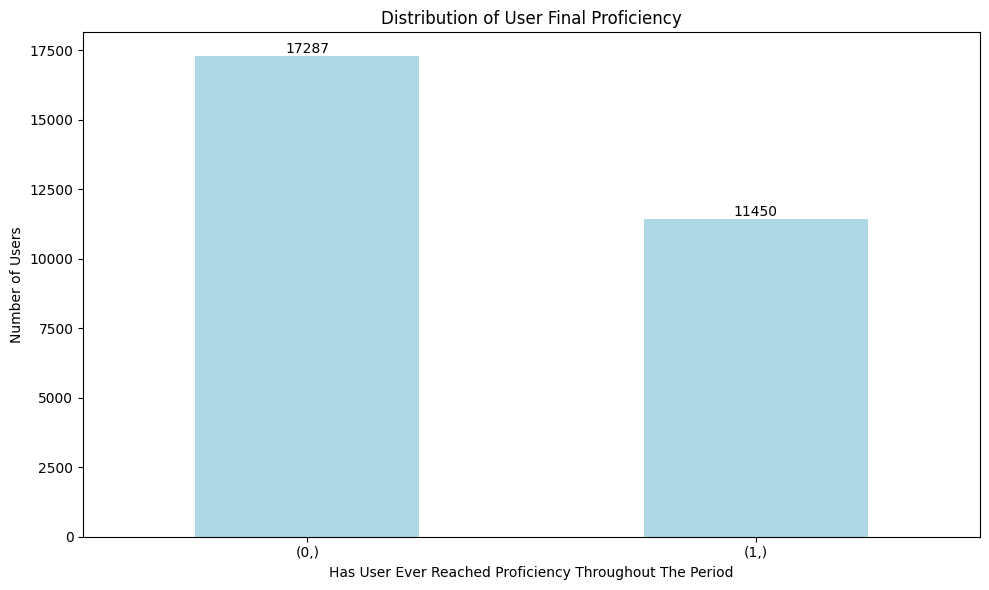

In [ ]:
import matplotlib.pyplot as plt
value_counts = df_user['proficient'].value_counts()
plt.figure(figsize=(10, 6))
bars = value_counts.plot(kind='bar', color='lightblue')
plt.title('Distribution of User Final Proficiency')
plt.xlabel('Has User Ever Reached Proficiency Throughout The Period')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., yval + 0.1, int(yval), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
#Train, valid, test split for df_user
from sklearn.model_selection import StratifiedShuffleSplit
target = 'proficient'
X = df_user.drop(target, axis=1)
y = df_user[target]
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_val_idx, test_idx = next(sss_test.split(X, y))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(sss_val.split(X_train_val, y_train_val))

X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

# Functions Preparation

## GNN

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from torch_geometric.explain import ModelConfig

def make_graph_tiny(df_raw,*,edge_types=('upid', 'ucid'),stratified_split=True,scale=True,seed=42,train_ratio=0.60,val_ratio=0.20):
    base_cols = [
        'last_activity', 'uuid', 'ucid', 'upid', 'problem_number',
        'exercise_problem_repeat_session', 'is_correct', 'total_sec_taken',
        'total_attempt_cnt', 'is_hint_used','first_login_date_TW', 'user_grade',
        'is_self_coach_x','learning_stage_elementary', 'learning_stage_junior',
        'learning_stage_senior', 'difficulty_easy', 'difficulty_hard',
        'difficulty_normal', 'user_city_encoded',
        'hour', 'day_of_week', 'month', 'year',
        'rolling_login_7d','max_days_since_first_login', 'avg_hints', 'has_teacher',
        'has_student', 'belongs_to_class', 'has_class',
        'avg_weekly_login_freq', 'proficient']
    kept = [c for c in base_cols if c in df_raw.columns]
    df   = df_raw[kept].copy()

    for col in ('upid', 'ucid'):
        if col in df.columns:
            freq = df[col].value_counts()
            df[f'{col}_freq'] = df[col].map(freq).astype(np.float32)
    df.drop(columns=[c for c in ('upid', 'ucid') if c in df.columns], inplace=True)

    num_cols = df.select_dtypes(include=['number', 'bool']).columns.tolist()
    num_cols.remove('proficient')
    if scale and num_cols:
        scaler = StandardScaler()
        df[num_cols] = scaler.fit_transform(df[num_cols]).astype(np.float32)

    g = (df.groupby('uuid', sort=False).agg({**{c: 'mean' for c in num_cols}, 'proficient': 'max'}).reset_index())

    g['node_id']  = np.arange(len(g), dtype=np.int32)
    feat_cols     = [c for c in g.columns if c not in ('uuid', 'proficient', 'node_id')]
    x = torch.tensor(g[feat_cols].to_numpy(dtype=np.float32, copy=False))
    y = torch.tensor(g['proficient'].to_numpy(dtype=np.int64, copy=False))

    node_id  = g['node_id'].to_numpy()
    edge_src = node_id.copy()
    edge_dst = node_id.copy()
    edge_tp  = np.zeros_like(edge_src, dtype=np.int8) # 0=self

    ET, id_maps = {'upid': 1, 'ucid': 2}, {}
    for et in edge_types:
        if et not in df_raw.columns:
            continue
        if et not in id_maps:
            id_maps[et] = (df_raw.drop_duplicates('uuid')
                                     .set_index('uuid')[et])
        g[et] = g['uuid'].map(id_maps[et])

        for _, grp in g.groupby(et, sort=False):
            nodes = grp['node_id'].to_numpy()
            if len(nodes) < 2:
                continue
            hub, others = nodes[0], nodes[1:]
            edge_src = np.concatenate([edge_src,np.repeat(hub, len(others)),others])
            edge_dst = np.concatenate([edge_dst,others,np.repeat(hub, len(others))])
            edge_tp  = np.concatenate([edge_tp,np.full(len(others), ET[et], np.int8),np.full(len(others), ET[et], np.int8)])

    edge_index = torch.as_tensor(np.vstack([edge_src, edge_dst]), dtype=torch.long)
    edge_type  = torch.as_tensor(edge_tp, dtype=torch.int8)
    data = Data(x=x, edge_index=edge_index, edge_type=edge_type, y=y)

    n = data.num_nodes
    data.train_mask = torch.zeros(n, dtype=torch.bool)
    data.val_mask   = torch.zeros(n, dtype=torch.bool)
    data.test_mask  = torch.zeros(n, dtype=torch.bool)

    idx_all = np.arange(n, dtype=np.int32)

    if stratified_split:
        sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
        train_val_idx, test_idx = next(sss_test.split(idx_all, y.numpy()))
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
        train_idx, val_idx = next(sss_val.split(train_val_idx, y[train_val_idx].numpy()))
    else:
        rng   = np.random.default_rng(seed)
        idx   = rng.permutation(n)
        cut1  = int(train_ratio * n)
        cut2  = int((train_ratio + val_ratio) * n)
        train_idx, val_idx, test_idx = idx[:cut1], idx[cut1:cut2], idx[cut2:]

    data.train_mask[torch.as_tensor(train_idx)] = True
    data.val_mask  [torch.as_tensor(val_idx)]   = True
    data.test_mask [torch.as_tensor(test_idx)]  = True

    print(f"Split → train:{data.train_mask.sum().item()}  "
          f"val:{data.val_mask.sum().item()}  "
          f"test:{data.test_mask.sum().item()}")
    return data, feat_cols

def run_experiment_classification(data,model_type,feat_cols,*,hidden_channels=64,lr=1e-3,dropout=0.5,epochs=100,heads=2,do_explain=True):
    import importlib
    has_numpy = importlib.util.find_spec("numpy") is not None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data   = copy.deepcopy(data).to(device)
    num_classes = int(data.y.max().item()) + 1

    if model_type == 'GCN':
        model = GCN(hidden_channels, out_channels=num_classes,dropout=dropout).to(device)
    elif model_type == 'GAT':
        model = GAT(hidden_channels, out_channels=num_classes,heads=heads, dropout=dropout).to(device)
    elif model_type == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, out_channels=num_classes).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn   = nn.CrossEntropyLoss()
    to_list   = lambda t: t.detach().cpu().tolist()

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        out  = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == 1:
            with torch.no_grad():
                preds = out[data.train_mask].argmax(dim=1)
                true  = data.y[data.train_mask]

                train_acc = accuracy_score(to_list(true), to_list(preds))
                train_f1_w = f1_score(to_list(true), to_list(preds), average='weighted')
                train_f1_macro = f1_score(to_list(true), to_list(preds), average='macro')
                train_f1_micro = f1_score(to_list(true), to_list(preds), average='micro')

            #print(f"[{model_type}] Epoch {epoch:03d} | " f"Loss: {loss:.4f} | " f"Acc: {train_acc:.4f} | " f"F1-w: {train_f1_w:.4f} | "f"F1-M: {train_f1_macro:.4f} | " f"F1-μ: {train_f1_micro:.4f}")

    model.eval()
    with torch.no_grad():
        out  = model(data.x, data.edge_index)
        pred = out[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]

        test_acc = accuracy_score(to_list(true), to_list(pred))
        test_f1  = f1_score(to_list(true), to_list(pred), average='weighted')

    print(f"[{model_type}] Test Acc: {test_acc:.4f} | " f"F1: {test_f1:.4f} | " f"F1 Macro: {train_f1_macro:.4f} | " f"F1 Weighted: {train_f1_w:.4f}")

    node_index = int(data.test_mask.nonzero(as_tuple=True)[0][0])
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs'
        ),
    )
    explanation = explainer(data.x, data.edge_index, index=node_index)
    print(f"Available explanations: {explanation.available_explanations}")
    explanation.visualize_feature_importance('feature_importance.png', top_k=10)
    explanation.visualize_graph('subgraph.pdf')
    fig_feat = explanation.visualize_feature_importance(path=None, top_k=10)
    display(fig_feat)

    cm = confusion_matrix(to_list(true), to_list(pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_type}")
    plt.savefig("confusion_matrix.png")
    plt.show()
    return test_acc, test_f1, model, data

_VAL_SPLIT_DONE = False
def objective_classification(trial, model_name, data, args,val_ratio: float = 0.15, seed: int = 42):
    global _VAL_SPLIT_DONE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if (not hasattr(data, "val_mask")) or (data.val_mask.sum() == 0):
        if not _VAL_SPLIT_DONE:
            rng = torch.Generator().manual_seed(seed)
            train_idx = data.train_mask.nonzero(as_tuple=True)[0]
            perm      = train_idx[torch.randperm(len(train_idx), generator=rng)]
            cut       = int(len(perm) * (1 - val_ratio))
            new_train, val = perm[:cut], perm[cut:]

            data.train_mask[:]        = False
            data.train_mask[new_train] = True
            data.val_mask             = torch.zeros_like(data.train_mask)
            data.val_mask[val]        = True
            _VAL_SPLIT_DONE = True
        else:
            pass

    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64])
    lr              = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout         = trial.suggest_float('dropout', 0.2, 0.6)
    num_classes = int(data.y.max().item()) + 1

    if model_name == 'GCN':
        model = GCN(hidden_channels, num_classes, dropout=dropout).to(device)
    elif model_name == 'GAT':
        heads  = getattr(args, "heads", 4)
        model  = GAT(hidden_channels, num_classes, heads=heads,
                     dropout=dropout).to(device)
    elif model_name == 'GraphSAGE':
        model = GraphSAGE(hidden_channels, num_classes).to(device)
    else:
        raise ValueError(f"Unknown model {model_name}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_fn   = nn.CrossEntropyLoss()
    data_copy = copy.deepcopy(data).to(device)

    best_val_acc = 0.0
    for epoch in range(args.epochs):
        model.train()
        optimizer.zero_grad()
        out  = model(data_copy.x, data_copy.edge_index)
        loss = loss_fn(out[data_copy.train_mask], data_copy.y[data_copy.train_mask])
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            out_val  = model(data_copy.x, data_copy.edge_index)
            val_pred = out_val[data_copy.val_mask].argmax(dim=1)
            val_true = data_copy.y[data_copy.val_mask]
            val_acc  = (val_pred == val_true).float().mean().item()
            best_val_acc = max(best_val_acc, val_acc)
        trial.report(1 - val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    del model, optimizer, data_copy
    torch.cuda.empty_cache()
    return 1 - best_val_acc

In [ ]:

class GCN(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GraphConv(-1, hidden_channels)
        self.conv2 = GraphConv(-1, out_channels)
        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, x, edge_index):
        x = self.dropout_layer(x)
        x = self.conv1(x, edge_index).relu()
        x = self.dropout_layer(x)
        x = self.conv2(x, edge_index)
        return x

class GAT(nn.Module):
    def __init__(self, hidden_channels, out_channels, heads=8, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=dropout, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=dropout, add_self_loops=False)
        self.conv3 = GATConv((-1, -1), out_channels, heads=1, concat=False, dropout=dropout, add_self_loops=False)
        self.norm1 = nn.LayerNorm(hidden_channels * heads)
        self.norm2 = nn.LayerNorm(hidden_channels * heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.norm1(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.norm2(x)

        x = self.conv3(x, edge_index)
        return x

class GraphSAGE(nn.Module):
    def __init__(self, hidden_channels, out_channels, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

## EvolveGCN

In [ ]:
#0617
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import coo_matrix, csr_matrix, diags, eye
from torch_geometric.explain import Explainer, GNNExplainer
import matplotlib.pyplot as plt
import optuna


class EvolveGCNLayerH(nn.Module):
    def __init__(self, in_dim, out_dim, p_drop=0.27495287200170593):
        super().__init__()
        self.in_dim, self.out_dim = in_dim, out_dim
        flat = in_dim * out_dim
        # GRUCell now takes embedding summary of size out_dim as input, hidden state of size flat
        self.gru = nn.GRUCell(out_dim, flat)
        self.drop = nn.Dropout(p_drop)

    def forward(self, X, A, W_prev):
        # 1) Graph convolution
        H = torch.sparse.mm(A, X) @ W_prev

        # 2) Summarize node embeddings and evolve weights
        H_mean = H.mean(dim=0, keepdim=True)         # [1, out_dim]
        w_prev_flat = W_prev.view(1, -1)             # [1, flat]
        w_next_flat = self.gru(H_mean, w_prev_flat)  # input_size=out_dim, hidden_size=flat
        W_next = w_next_flat.view(self.in_dim, self.out_dim)

        # 3) Activation + dropout
        H = F.relu(H)
        H = self.drop(H)
        return H, W_next
class EvolveGCN_H(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, p_drop=0.27495287200170593):
        super().__init__()
        self.layer1 = EvolveGCNLayerH(in_dim, hidden_dim, p_drop)
        self.layer2 = EvolveGCNLayerH(hidden_dim, out_dim, p_drop)
        self.W1 = nn.Parameter(torch.empty(in_dim, hidden_dim))
        self.W2 = nn.Parameter(torch.empty(hidden_dim, out_dim))
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)

    def forward(self, X_list, A_list, return_all=False):
        W1, W2 = self.W1, self.W2
        H2_seq = []
        for X, A in zip(X_list, A_list):
            H1, W1 = self.layer1(X, A, W1)
            H2, W2 = self.layer2(H1, A, W2)
            if return_all:
                H2_seq.append(H2)
        return H2_seq if return_all else H2

def csr_to_sparse_coo_tensor(mat: csr_matrix, device='cpu') -> torch.sparse_coo_tensor:
    coo = mat.tocoo()
    idx_np = np.vstack((coo.row.astype(np.int64), coo.col.astype(np.int64)))
    val_np = coo.data.astype(np.float32)
    idx = torch.from_numpy(idx_np).to(dtype=torch.long, device=device)
    vals = torch.from_numpy(val_np).to(dtype=torch.float32, device=device)
    return torch.sparse_coo_tensor(idx, vals, size=coo.shape, device=device).coalesce()

# normalization helper unchanged

def normalize_adjacency(adj):
    if not isinstance(adj, csr_matrix):
        adj = csr_matrix(adj)
    n = adj.shape[0]
    adj = adj + eye(n, format='csr')
    deg = np.array(adj.sum(1)).flatten()
    inv_sqrt = np.power(deg, -0.5, where=deg>0)
    inv_sqrt[deg==0] = 0.0
    D_inv_sqrt = diags(inv_sqrt)
    return (D_inv_sqrt @ adj @ D_inv_sqrt).tocsr()

# --- 2. Build snapshots with co‐attempt edges ---
def build_snapshots_with_co_attempt(
    df,
    time_col='last_activity',
    uuid_col='uuid',
    label_col='proficient',
    ucid_col='ucid',
    snapshot_freq='W',
    feature_cols=None,
    dropna=True
):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df['snapshot'] = df[time_col].dt.to_period(snapshot_freq).dt.to_timestamp()

    # global UUID→int map
    enc = LabelEncoder()
    df['uuid_id'] = enc.fit_transform(df[uuid_col])
    all_node_ids = df['uuid_id'].unique()
    num_nodes = len(all_node_ids)

    if feature_cols is None:
        exclude = {time_col, uuid_col, label_col, ucid_col, 'snapshot', 'uuid_id'}
        feature_cols = [c for c in df.columns if c not in exclude]
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    snapshots = []
    for t, grp in df.groupby('snapshot'):
        # collect co‐attempt edges + self‐loops
        rows, cols = [], []
        for ucid, sg in grp.groupby(ucid_col):
            idxs = sg['uuid_id'].unique().astype(int).tolist()
            for i,j in itertools.combinations(idxs,2):
                rows += [i,j]; cols += [j,i]
            rows += idxs; cols += idxs

        data = np.ones(len(rows), dtype=np.float32)
        mat  = coo_matrix((data,(rows,cols)), shape=(num_nodes, num_nodes))
        adj  = normalize_adjacency(mat)

        # features
        fdf = grp.groupby('uuid_id')[feature_cols].mean()
        feats = np.zeros((num_nodes, fdf.shape[1]), dtype=np.float32)
        idxs = fdf.index.astype(int).tolist()
        feats[idxs] = fdf.values

        # labels (only last snapshot will have non‐negatives)
        labels = np.full((num_nodes,), -1, dtype=np.int64)
        lseries = grp.groupby('uuid_id')[label_col].first()
        lidx   = lseries.index.astype(int).tolist()
        labels[lidx] = lseries.values

        snapshots.append({
            'time':     t,
            'adj':      adj,
            'features': feats,
            'labels':   labels,
            'node_ids': all_node_ids
        })

    return snapshots, enc

# helper to convert a list of snapshots → tensors + mask + labels
def prep_sn(sn_list, device):
    X_list = [torch.tensor(s['features'], dtype=torch.float32, device=device)
              for s in sn_list]
    A_list = [csr_to_sparse_coo_tensor(s['adj'], device=device)
              for s in sn_list]

    # only the *last* snapshot has true labels in s['labels'] (others are all -1)
    labels_full = torch.tensor(sn_list[-1]['labels'], dtype=torch.long, device=device)
    mask = (labels_full != -1)
    labels = labels_full[mask]
    return X_list, A_list, mask, labels

def train_epoch_all_steps(model, optimizer, loss_fn, snapshots, device):
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0

    # Prepare data once
    X_list = [torch.tensor(s['features'], dtype=torch.float32, device=device)
              for s in snapshots]
    A_list = [csr_to_sparse_coo_tensor(s['adj'], device=device)
              for s in snapshots]

    # Forward to get list of H2 outputs
    H_seq = model(X_list, A_list, return_all=True)

    # For each time‐step, compute loss on any nodes that have a label
    for H, snap in zip(H_seq, snapshots):
        labels = torch.tensor(snap['labels'], dtype=torch.long, device=device)
        mask   = (labels != -1)
        if mask.any():
            out     = H[mask]            # logits for labeled nodes
            y_true  = labels[mask]
            total_loss += loss_fn(out, y_true)

    total_loss.backward()
    optimizer.step()
    return total_loss.item()

def eval_model(model, X_list, A_list, mask, labels):
    model.eval()
    with torch.no_grad():
        out = model(X_list, A_list)[mask]
        preds = out.argmax(dim=1).cpu().numpy()
        y = labels.cpu().numpy()
    return accuracy_score(y, preds), f1_score(y, preds, average='weighted')

# Experiment

## Majority Baseline

In [ ]:
#majority baseline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
zero_r = DummyClassifier(strategy="most_frequent")
zero_r.fit(X_train, y_train)
y_pred = zero_r.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75      3458
           1       0.00      0.00      0.00      2290

    accuracy                           0.60      5748
   macro avg       0.30      0.50      0.38      5748
weighted avg       0.36      0.60      0.45      5748



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## RF

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats

df_sampled = df.sample(frac=0.01, random_state=42)
X_sample = df_sampled.drop(columns=drop_cols)
y_sample = df_sampled['points']
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42,)
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 10],
    'max_features': ['sqrt']
}
grid_search = GridSearchCV(rf_model,param_grid=param_grid,cv=2,scoring='accuracy',n_jobs=1)
grid_search.fit(X_sample_train, y_sample_train)
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best Hyperparameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


Test
Accuracy:0.808
F1 (macro):0.794
F1 (weighted):0.805
ROC-AUC: 0.884

Classification report
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      3458
           1       0.80      0.69      0.74      2290

    accuracy                           0.81      5748
   macro avg       0.81      0.79      0.79      5748
weighted avg       0.81      0.81      0.80      5748



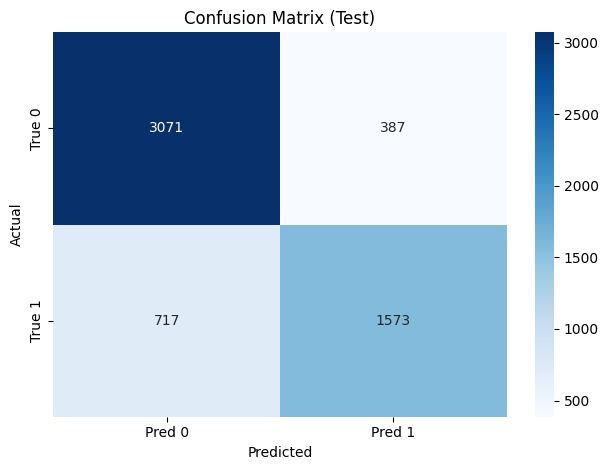

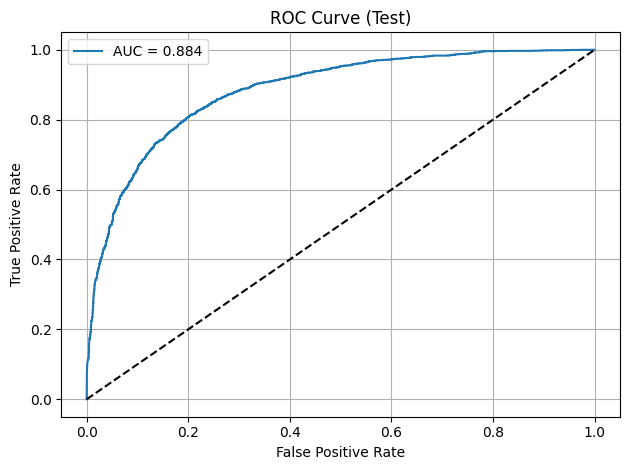

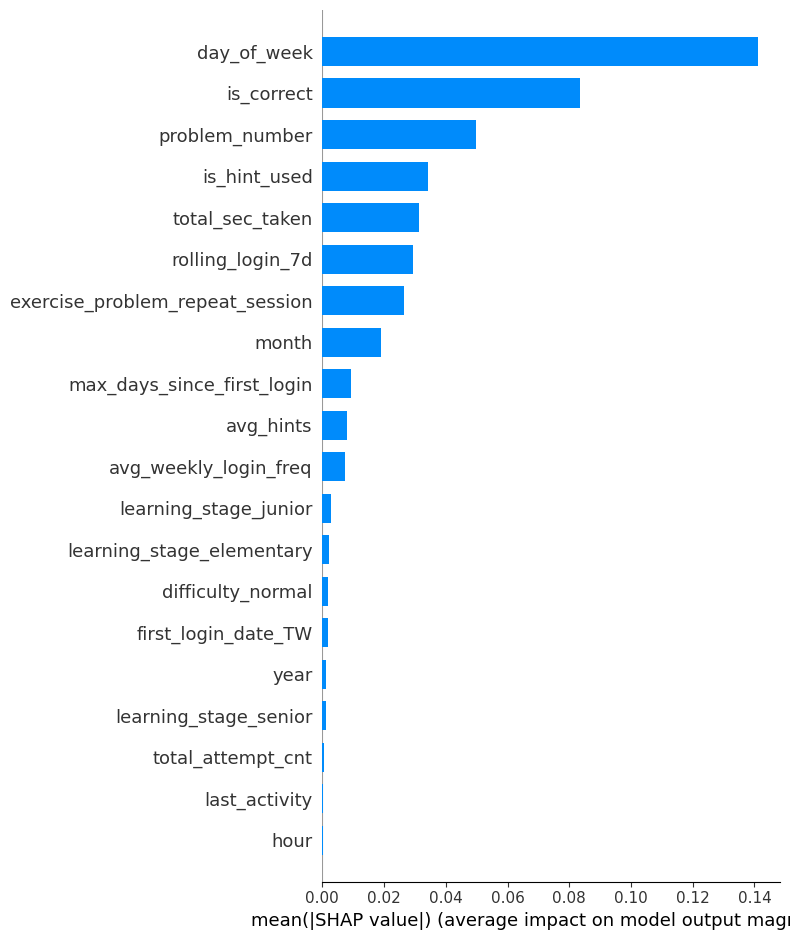

In [ ]:
#take this for result
rf = RandomForestClassifier(max_depth=10,max_features=0.5,n_estimators=100,min_samples_leaf=5,bootstrap=True,n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)
y_val_pred  = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]
y_test_pred  = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("Test")
print(f"Accuracy:{accuracy_score(y_test, y_test_pred):.3f}")
print(f"F1 (macro):{f1_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"F1 (weighted):{f1_score(y_test, y_test_pred, average='weighted'):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.3f}\n")
print("Classification report\n", classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Pred 0', 'Pred 1'],yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)'); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

if X_test.shape[0] < X_test.shape[1]:
    X_test = X_test.T
if isinstance(X_test.columns, pd.MultiIndex):
    X_test.columns = ['{}_{}'.format(a, b) if b else str(a) for a, b in X_test.columns]
explainer = shap.TreeExplainer(rf, model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:, :, 1], features=X_test, feature_names=X_test.columns, plot_type='bar')

## GNN

In [ ]:
feat_cols

['problem_number',
 'exercise_problem_repeat_session',
 'is_correct',
 'total_sec_taken',
 'total_attempt_cnt',
 'is_hint_used',
 'user_grade',
 'is_self_coach_x',
 'learning_stage_elementary',
 'learning_stage_junior',
 'learning_stage_senior',
 'difficulty_easy',
 'difficulty_hard',
 'difficulty_normal',
 'user_city_encoded',
 'hour',
 'day_of_week',
 'month',
 'year',
 'rolling_login_7d',
 'max_days_since_first_login',
 'avg_hints',
 'has_teacher',
 'has_student',
 'belongs_to_class',
 'has_class',
 'avg_weekly_login_freq',
 'upid_freq',
 'ucid_freq']

### Result

[GCN] Test Acc: 0.8154 | F1: 0.8169 | F1 Macro: 0.7893 | F1 Weighted: 0.7948
Available explanations: ['node_mask', 'edge_mask']


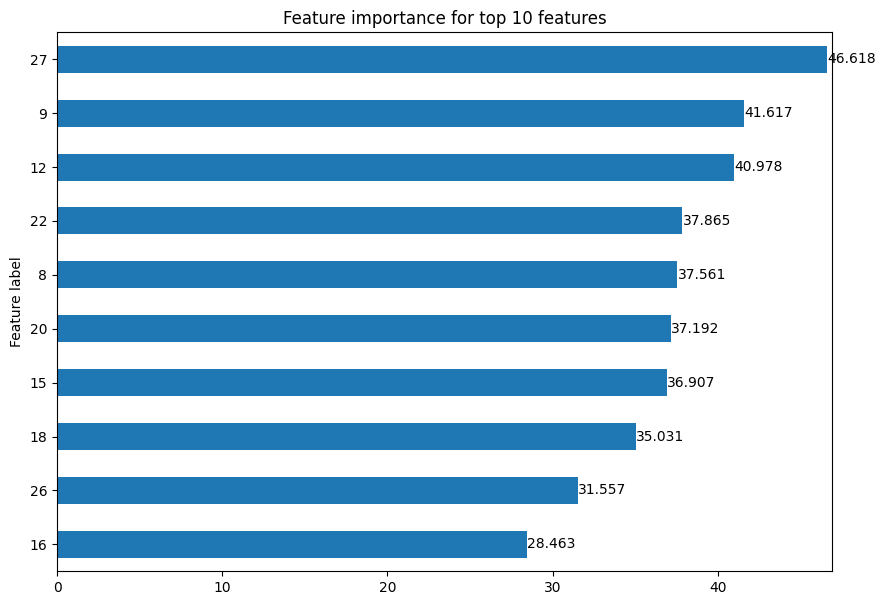

None

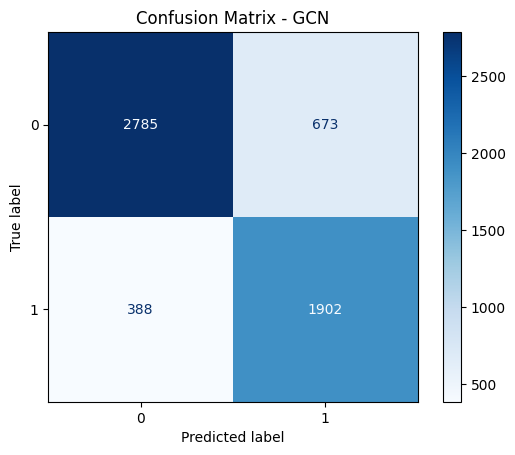

In [ ]:
#GCN
test_acc, test_f1, model, _ = run_experiment_classification(data,'GCN',feat_cols,hidden_channels=64,lr=0.008523295510961308,dropout=0.23044751904196414,epochs=500)

[GAT] Test Acc: 0.7055 | F1: 0.7058 | F1 Macro: 0.6504 | F1 Weighted: 0.6640
Available explanations: ['node_mask', 'edge_mask']


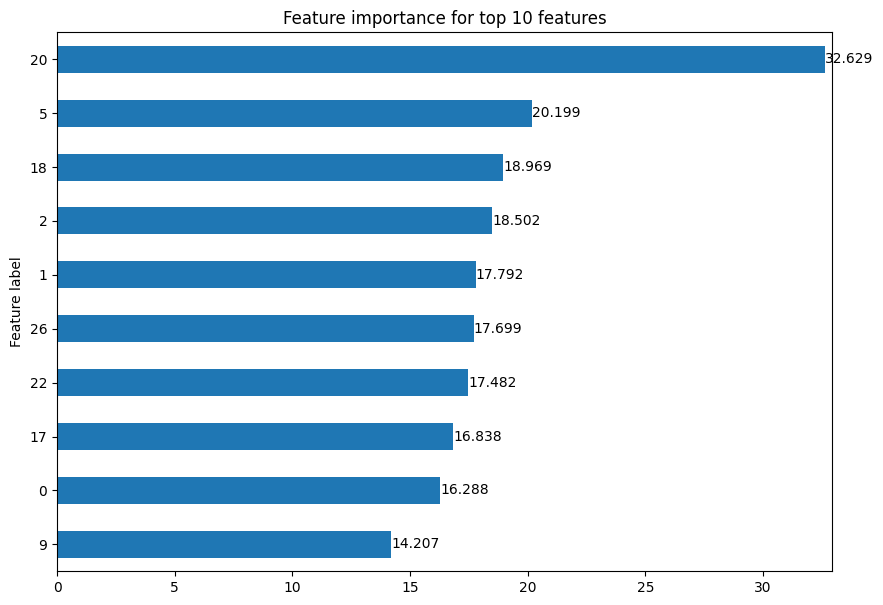

None

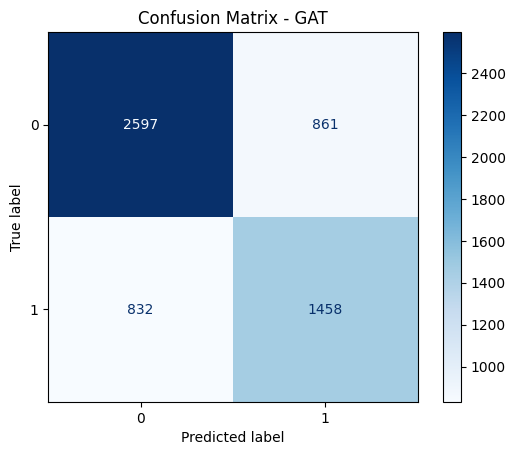

In [ ]:
#GAT
test_acc, test_f1, model, _ = run_experiment_classification(data,'GAT',feat_cols,hidden_channels=32,lr=0.00529352947539645,dropout=0.2089373218331943,epochs=500)

[GraphSAGE] Test Acc: 0.8081 | F1: 0.8101 | F1 Macro: 0.8185 | F1 Weighted: 0.8231
Available explanations: ['node_mask', 'edge_mask']


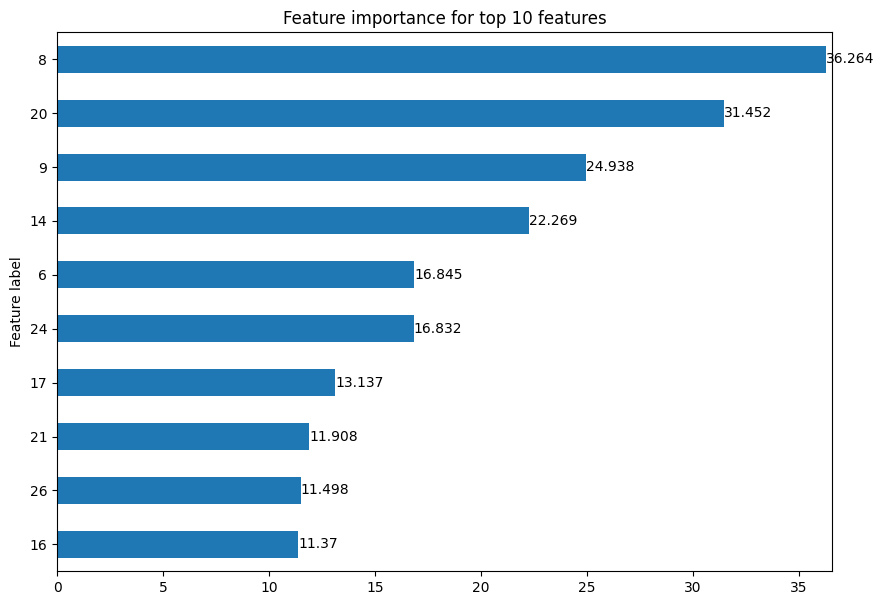

None

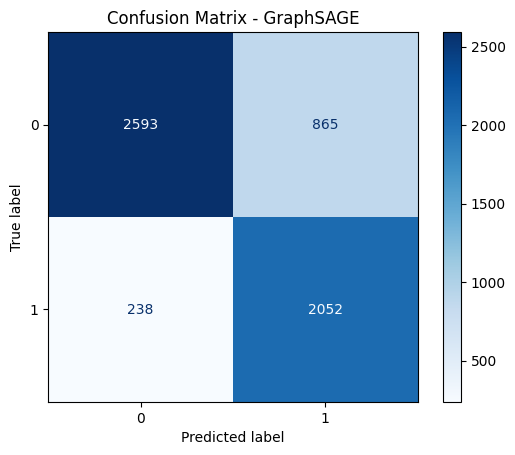

In [ ]:
#GraphSAGE
test_acc, test_f1, model, _ = run_experiment_classification(data,'GraphSAGE',feat_cols,hidden_channels=64,lr=0.009092764903556424,dropout=0.4910661369759407,epochs=500)

### Hyperparameter

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GCN', data, args), n_trials=500)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-12 16:20:50,933] A new study created in memory with name: no-name-bf9cb97c-c74a-48a7-918f-3831d22ed20b
[I 2025-06-12 16:20:51,071] Trial 0 finished with value: 0.3820459290187892 and parameters: {'hidden_channels': 64, 'lr': 0.000622341861841825, 'dropout': 0.5019099490144037}. Best is trial 0 with value: 0.3820459290187892.
[I 2025-06-12 16:20:51,212] Trial 1 finished with value: 0.4410229645093946 and parameters: {'hidden_channels': 32, 'lr': 0.0002869039390352668, 'dropout': 0.4555142196004715}. Best is trial 0 with value: 0.3820459290187892.
[I 2025-06-12 16:20:51,347] Trial 2 finished with value: 0.32045929018789143 and parameters: {'hidden_channels': 64, 'lr': 0.0028856856444261685, 'dropout': 0.4950827205691987}. Best is trial 2 with value: 0.32045929018789143.
[I 2025-06-12 16:20:51,484] Trial 3 finished with value: 0.44363256784968685 and parameters: {'hidden_channels': 16, 'lr': 0.0006497536061322568, 'dropout': 0.4687356146466169}. Best is trial 2 with value: 0.32


Best trial:
  Value (1 - accuracy): 0.2550
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.008523295510961308
    dropout: 0.23044751904196414


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GAT', data, args), n_trials=500)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-12 16:22:07,932] A new study created in memory with name: no-name-71345e4f-aead-42e0-9e8f-13ac51b4b2b1
[I 2025-06-12 16:22:08,269] Trial 0 finished with value: 0.3683020180932498 and parameters: {'hidden_channels': 16, 'lr': 0.0010836837949582978, 'dropout': 0.24012904646722322}. Best is trial 0 with value: 0.3683020180932498.
[I 2025-06-12 16:22:08,595] Trial 1 finished with value: 0.41701461377870563 and parameters: {'hidden_channels': 16, 'lr': 0.00018518776747019074, 'dropout': 0.4155661835576262}. Best is trial 0 with value: 0.3683020180932498.
[I 2025-06-12 16:22:09,152] Trial 2 finished with value: 0.36743215031315235 and parameters: {'hidden_channels': 64, 'lr': 0.001915462449488752, 'dropout': 0.4238770961516266}. Best is trial 2 with value: 0.36743215031315235.
[I 2025-06-12 16:22:09,482] Trial 3 finished with value: 0.3564718162839249 and parameters: {'hidden_channels': 32, 'lr': 0.008270335623737765, 'dropout': 0.4058184933105776}. Best is trial 3 with value: 0.3


Best trial:
  Value (1 - accuracy): 0.3427
  Best hyperparameters:
    hidden_channels: 32
    lr: 0.00529352947539645
    dropout: 0.2089373218331943


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_classification(trial, 'GraphSAGE', data, args), n_trials=500)
print("\nBest trial:")
print(f"  Value (1 - accuracy): {study.best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-12 16:25:07,765] A new study created in memory with name: no-name-0ec16fb9-1806-4ccb-8664-f0c4ce7f7585
[I 2025-06-12 16:25:07,958] Trial 0 finished with value: 0.5139178844815588 and parameters: {'hidden_channels': 16, 'lr': 0.0002810537468471202, 'dropout': 0.21410869569101126}. Best is trial 0 with value: 0.5139178844815588.
[I 2025-06-12 16:25:08,109] Trial 1 finished with value: 0.43493389004871263 and parameters: {'hidden_channels': 32, 'lr': 0.00013071051656052016, 'dropout': 0.5478367622829822}. Best is trial 1 with value: 0.43493389004871263.
[I 2025-06-12 16:25:08,259] Trial 2 finished with value: 0.31228253305497566 and parameters: {'hidden_channels': 16, 'lr': 0.002018088271867688, 'dropout': 0.27952489890120336}. Best is trial 2 with value: 0.31228253305497566.
[I 2025-06-12 16:25:08,405] Trial 3 finished with value: 0.2078983994432846 and parameters: {'hidden_channels': 64, 'lr': 0.009695221437663552, 'dropout': 0.558572156090152}. Best is trial 3 with value: 0.


Best trial:
  Value (1 - accuracy): 0.1942
  Best hyperparameters:
    hidden_channels: 64
    lr: 0.009092764903556424
    dropout: 0.4910661369759407


## EvolveGCN

In [ ]:
# --- 1) Build snapshots ---

exclude = ['last_activity','first_login_date_TW','proficient','uuid','ucid','upid']
feature_cols = [c for c in df.columns if c not in exclude]
snapshots, uuid_enc = build_snapshots_with_co_attempt(
    df, time_col='last_activity', uuid_col='uuid',
    label_col='proficient', ucid_col='ucid',
    snapshot_freq='W', feature_cols=feature_cols, dropna=True
)

# --- 2) Split to train/val/test ---
n = len(snapshots)
i1, i2 = int(0.6*n), int(0.8*n)
train_sn, val_sn, test_sn = snapshots[:i1], snapshots[i1:i2], snapshots[i2:]

device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = df['proficient'].nunique()

# --- 3) Precompute class weights ---
classes = np.array([0,1])
y_all = df['proficient'].values

cw = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_all
)
weights_tensor = torch.tensor(cw, dtype=torch.float32, device=device)

# --- 4) Prep PyTorch inputs helper ---
def prep_sn(sn_list, device):
    X = [torch.tensor(s['features'], dtype=torch.float32, device=device)
         for s in sn_list]
    A = [csr_to_sparse_coo_tensor(s['adj'], device=device)
         for s in sn_list]
    labels_full = torch.tensor(sn_list[-1]['labels'], dtype=torch.long, device=device)
    mask        = labels_full != -1
    labels      = labels_full[mask]
    return X, A, mask, labels

X_tr, A_tr, m_tr, y_tr = prep_sn(train_sn, device)
X_val, A_val, m_val, y_val = prep_sn(val_sn, device)
X_te, A_te, m_te, y_te = prep_sn(test_sn, device)


# --- 5) Define Optuna objective ---
def objective(trial):
    # sample hyperparams
    hidden_dim   = trial.suggest_categorical("hidden_dim", [32,64,128,256])
    dropout      = trial.suggest_float("dropout", 0.0, 0.5)
    lr           = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("wd", 1e-6, 1e-2)
    gamma        = trial.suggest_categorical("gamma", [0.5,0.7,0.9])

    # build model & optimizer
    model = EvolveGCN_H(X_tr[0].shape[1], hidden_dim, num_classes, p_drop=dropout).to(device)
    optim = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    sched = StepLR(optim, step_size=20, gamma=gamma)
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)

    best_val = 0.0
    for epoch in range(1,51):
        train_epoch_all_steps(model, optim, loss_fn, train_sn, device)
        val_acc, val_f1 = eval_model(model, X_val, A_val, m_val, y_val)
        sched.step()
        trial.report(val_f1, epoch)
        if trial.should_prune(): raise optuna.TrialPruned()
        best_val = max(best_val, val_f1)

    return best_val

# --- 6) Run hyperparameter search ---
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)
study.optimize(objective, n_trials=50, timeout=3600)
print("Best F1:", study.best_value)
print("Best params:", study.best_params)
best_params = study.best_params


[I 2025-06-17 10:07:10,316] A new study created in memory with name: no-name-05b62323-0ae1-41b5-aee7-3dc1ee11f698
<ipython-input-18-3120988148>:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr           = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-18-3120988148>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("wd", 1e-6, 1e-2)
[I 2025-06-17 10:08:48,674] Trial 0 finished with value: 0.5873573651432172 and parameters: {'hidden_dim': 256, 'dropout': 0.247863353835099, 'lr': 2.506135238806591e-05, 'wd': 6.830226055762033e-05, 'gamma': 0.7}. Best is trial 0 with value: 0.5873573651432172.
<ipython-input-18-3120988

Best F1: 0.6116033217837864
Best params: {'hidden_dim': 64, 'dropout': 0.297468968520313, 'lr': 0.0009305653464099255, 'wd': 5.576359010555286e-05, 'gamma': 0.9}


KeyboardInterrupt: 

→ Train Acc: 0.6320, F1: 0.6311
→ Test  Acc: 0.5504, F1: 0.4811


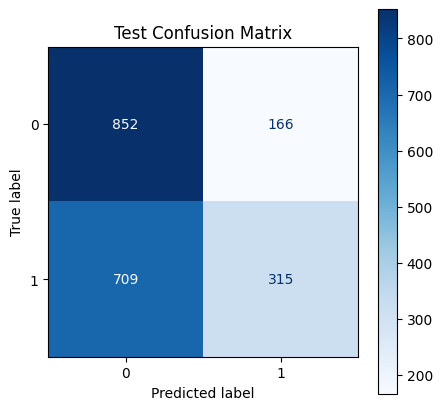

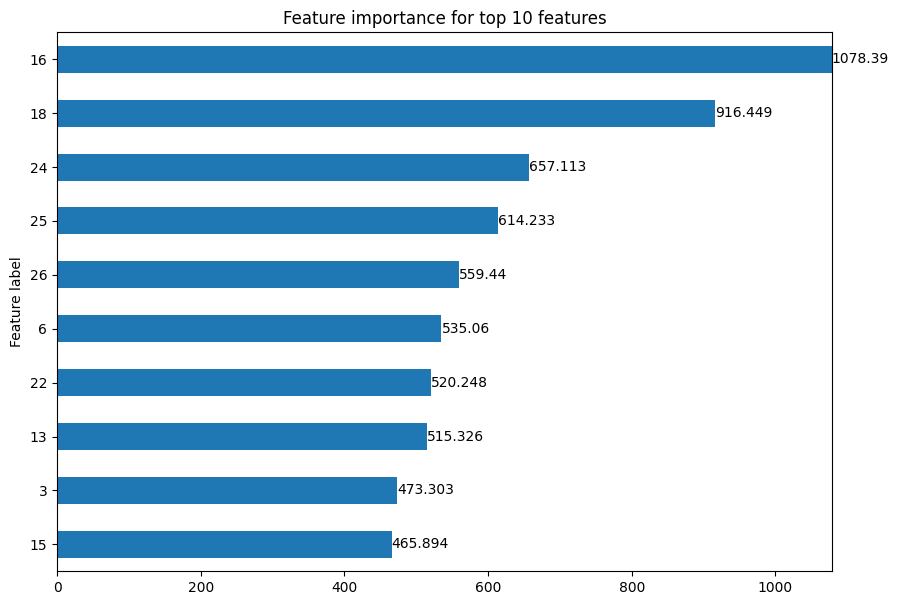

In [ ]:
# --- 7) Retrain on train+val with best params ---
combined_sn = train_sn + val_sn
model = EvolveGCN_H(X_tr[0].shape[1],64,num_classes,p_drop=0.297468968520313).to(device)

optimizer = AdamW(model.parameters(), lr=0.0009305653464099255, weight_decay=5.576359010555286e-05)
scheduler = StepLR(optimizer, step_size=20, gamma=0.9)
loss_fn   = torch.nn.CrossEntropyLoss(weight=weights_tensor)

for epoch in range(1,201):
    train_epoch_all_steps(model, optimizer, loss_fn, combined_sn, device)
    scheduler.step()

# --- 8) Final evaluation on test ---
model.eval()
train_acc, train_f1 = eval_model(model, X_tr, A_tr, m_tr, y_tr)
test_acc,  test_f1  = eval_model(model, X_te, A_te, m_te, y_te)
print(f"→ Train Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
print(f"→ Test  Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

cm = confusion_matrix(y_true_test, preds_test)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# --- 9) (Optional) Explain with GNNExplainer ---
X_graph    = X_te[-1]
A_graph    = A_te[-1].coalesce()
edge_index = A_graph.indices()
edge_weight= A_graph.values()
node_idx   = torch.nonzero(m_te, as_tuple=True)[0][0].item()

class ExplainerWrapper(nn.Module):
    def __init__(self, base_model): super().__init__(); self.base_model = base_model
    def forward(self, x, edge_index, edge_weight=None):
        if edge_weight is None:
            edge_weight = torch.ones(edge_index.size(1), device=x.device)
        A = torch.sparse_coo_tensor(edge_index, edge_weight,
                                    size=(x.size(0), x.size(0)),
                                    device=x.device).coalesce()
        return self.base_model([x], [A])

wrapper = ExplainerWrapper(model)
explainer = Explainer(
    model=wrapper,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs'
    )
)
exp = explainer(x=X_graph, edge_index=edge_index, edge_weight=edge_weight, index=node_idx)
fig_feat = exp.visualize_feature_importance(top_k=10)
plt.show()